In [1]:
# Cell 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", keras.__version__)


TensorFlow version: 3.5.0


In [2]:
# ============================================================================
# Cell 2: Setup Paths and Parameters
# ============================================================================

# Paths
data_dir = 'fish_dataset'

# Hyperparameters - OPTIMIZED
img_height, img_width = 128, 128  # Reduced from 224 for faster training
batch_size = 64  # Increased from 32
epochs = 50
learning_rate = 0.0003  # Reduced from 0.001

# Get class names
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

print(f"Found {num_classes} classes:")
for i, name in enumerate(class_names):
    count = len(os.listdir(os.path.join(data_dir, name)))
    print(f"{i+1}. {name}: {count} images")


Found 15 classes:
1. angelfish: 67 images
2. betta fish: 59 images
3. blue tang: 18 images
4. clownfish: 69 images
5. discus: 77 images
6. goldfish: 65 images
7. guppy: 65 images
8. lionfish: 72 images
9. manta ray: 71 images
10. moray eel: 70 images
11. parrotfish: 70 images
12. pufferfish: 63 images
13. seahorse: 6 images
14. swordfish: 63 images
15. zebrafish: 49 images


In [3]:


# ============================================================================
# Cell 3: Data Augmentation and Generators - IMPROVED
# ============================================================================

# LIGHTER augmentation - your original was too aggressive
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Reduced from 20
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 713 images belonging to 15 classes.
Found 171 images belonging to 15 classes.

Training samples: 713
Validation samples: 171


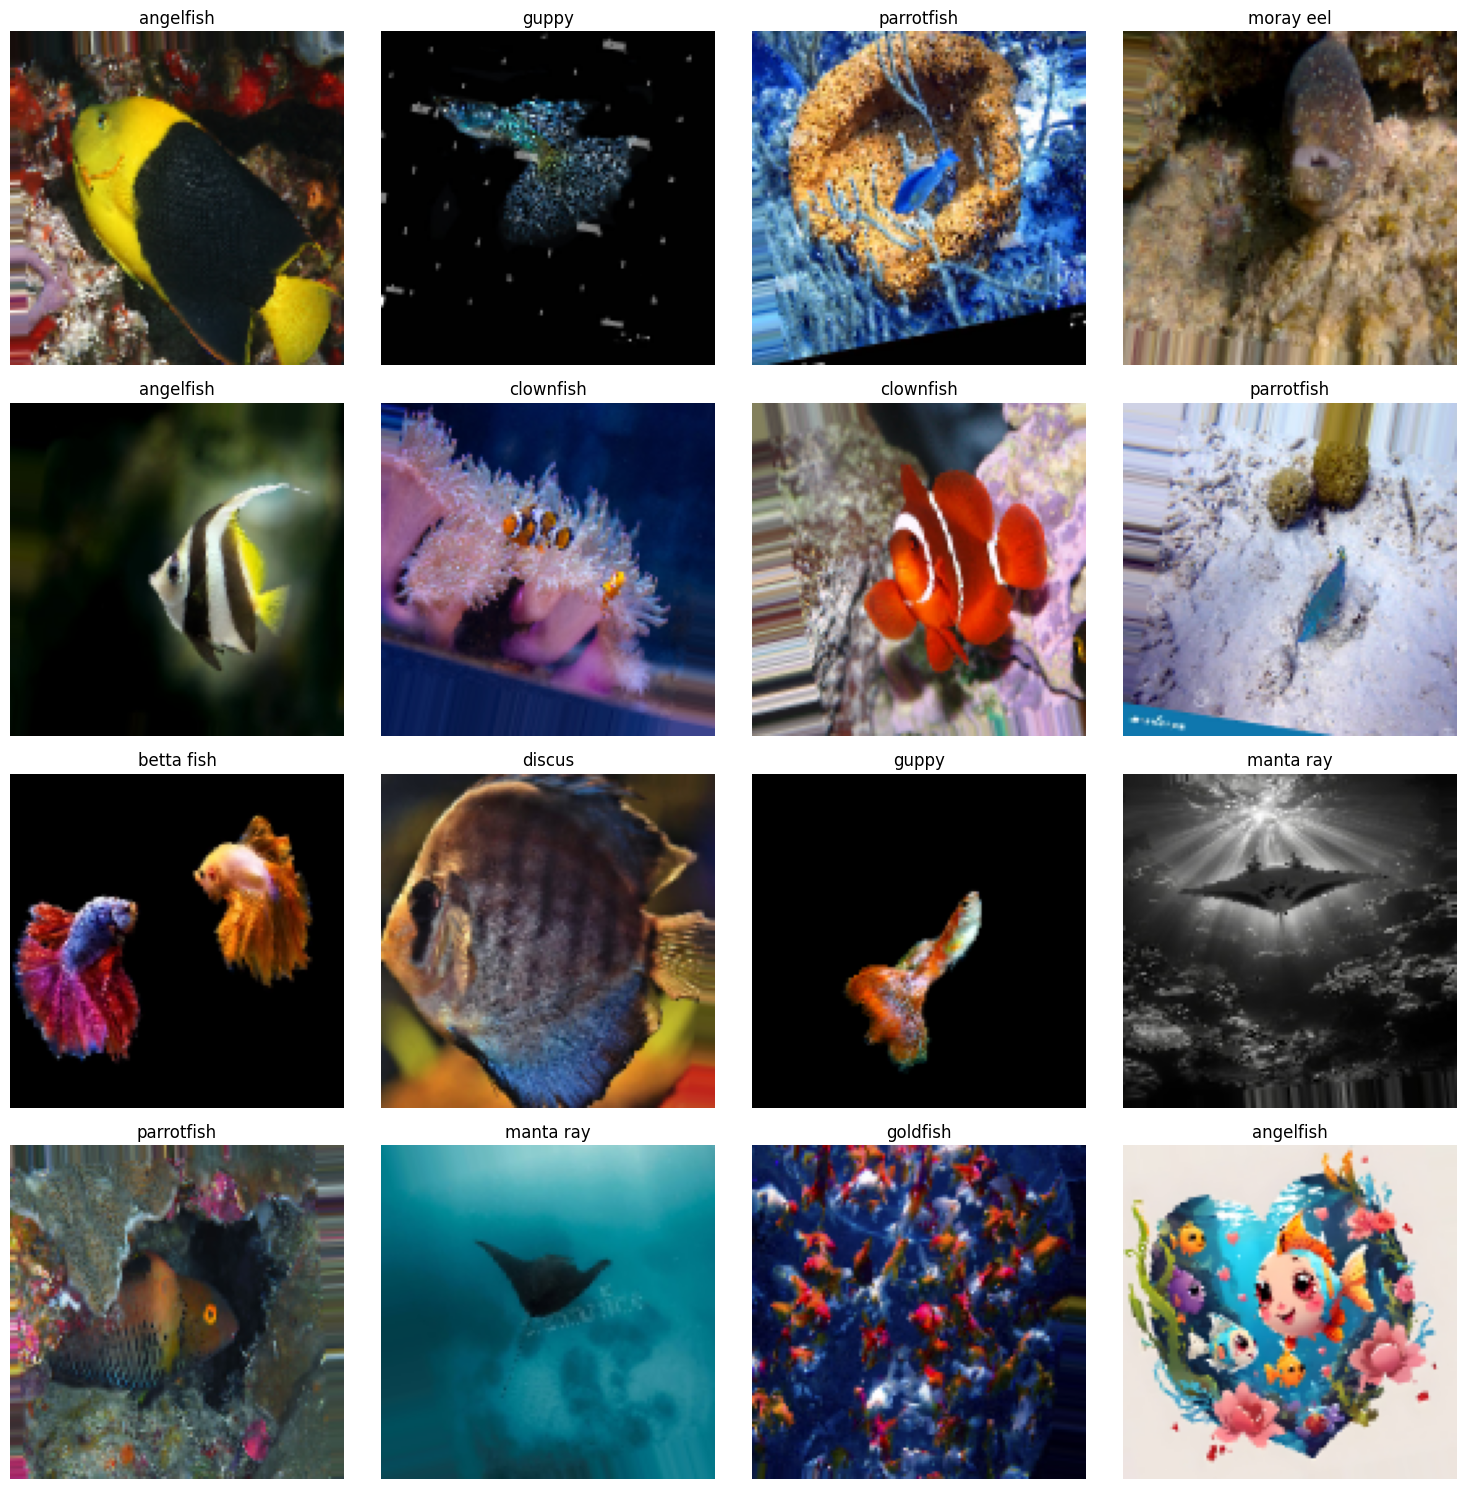

In [4]:


# ============================================================================
# Cell 4: Visualize Sample Images
# ============================================================================

images, labels = next(train_generator)

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:

# ============================================================================
# Cell 5: Build BETTER Model - Transfer Learning with MobileNetV2
# ============================================================================

def create_transfer_model():
    """
    Use transfer learning with MobileNetV2 - much better than training from scratch
    """
    base_model = MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

In [6]:


def create_simple_cnn():
    """
    Simpler CNN - your original was TOO DEEP for this dataset
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                      input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [7]:


# Choose model type
USE_TRANSFER_LEARNING = True  # Set to False to use simple CNN

if USE_TRANSFER_LEARNING:
    print("🚀 Using Transfer Learning (MobileNetV2)")
    model, base_model = create_transfer_model()
else:
    print("🚀 Using Simple CNN")
    model = create_simple_cnn()

model.summary()

🚀 Using Transfer Learning (MobileNetV2)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,919 (9.90 MB)

 Trainable params: 334,863 (1.28 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [8]:


# ============================================================================
# Cell 6: Compile Model
# ============================================================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,  # Reduced from 10
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_fish_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,  # Reduced from 5
        min_lr=1e-7,
        verbose=1
    )
]


In [9]:

# ============================================================================
# Cell 7: Train Model - TWO PHASE TRAINING
# ============================================================================

print("\n" + "="*60)
print("PHASE 1: Training with frozen base (if transfer learning)")
print("="*60)

history = model.fit(
    train_generator,
    epochs=15,  # Initial training
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# PHASE 2: Fine-tuning (only for transfer learning)
if USE_TRANSFER_LEARNING:
    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning with unfrozen layers")
    print("="*60)
    
    # Unfreeze the base model
    base_model.trainable = True
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Continue training
    history2 = model.fit(
        train_generator,
        epochs=epochs,
        initial_epoch=len(history.history['loss']),
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    # Merge histories
    for key in history.history.keys():
        history.history[key].extend(history2.history[key])

model.save('final_fish_model.keras')
print("\n✅ Model saved as 'final_fish_model.keras'")


PHASE 1: Training with frozen base (if transfer learning)
Epoch 1/15


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.0821 - loss: 3.4780
Epoch 1: val_accuracy improved from -inf to 0.26901, saving model to best_fish_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.0853 - loss: 3.4555 - val_accuracy: 0.2690 - val_loss: 2.3003 - learning_rate: 3.0000e-04
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.3162 - loss: 2.1999
Epoch 2: val_accuracy improved from 0.26901 to 0.49708, saving model to best_fish_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3220 - loss: 2.1831 - val_accuracy: 0.4971 - val_loss: 1.7321 - learning_rate: 3.0000e-04
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5598 - loss: 1.6066
Epoch 3: val_accuracy improved from 0.49708 to 0.63743, saving model to best_fish_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5598 - loss: 1.5993 - val_accuracy: 0.6374 - val_loss: 1.3995 - learning_rate: 3.0000e-04
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/s

KeyboardInterrupt: 

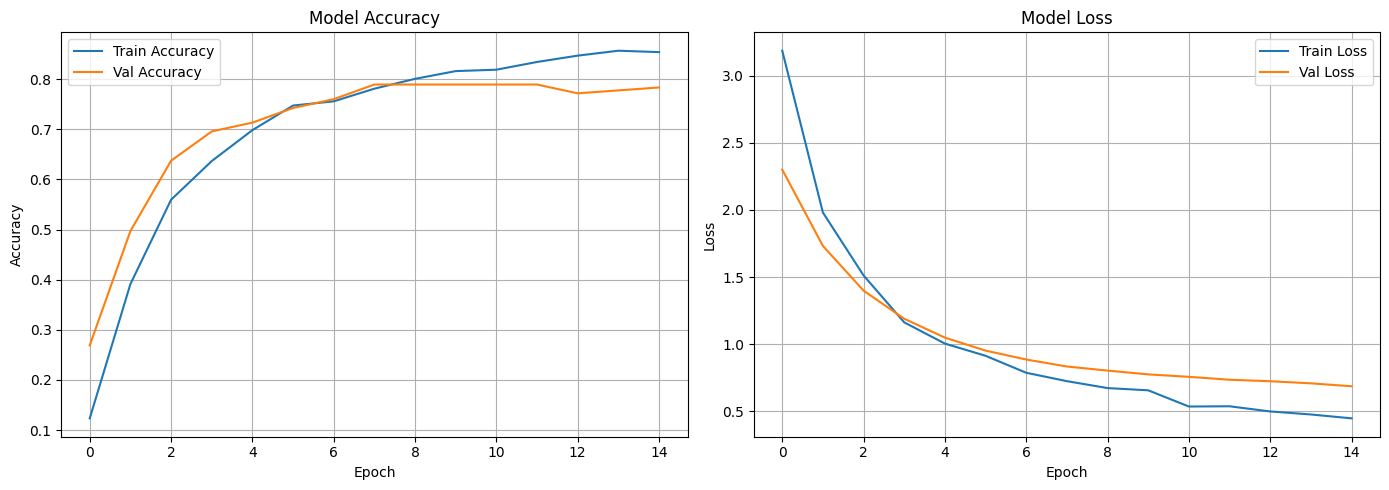


🏆 Best Validation Accuracy: 0.7895 at epoch 8
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step

📊 Classification Report:
              precision    recall  f1-score   support

   angelfish       0.83      0.77      0.80        13
  betta fish       0.67      0.91      0.77        11
   blue tang       1.00      0.67      0.80         3
   clownfish       0.92      0.92      0.92        13
      discus       0.82      0.93      0.87        15
    goldfish       0.85      0.85      0.85        13
       guppy       0.88      0.54      0.67        13
    lionfish       1.00      0.93      0.96        14
   manta ray       0.60      0.43      0.50        14
   moray eel       0.61      0.79      0.69        14
  parrotfish       0.77      0.71      0.74        14
  pufferfish       1.00      0.83      0.91        12
    seahorse       0.00      0.00      0.00         1
   swordfish       0.65      0.92      0.76        12
   zebrafish       0.80      0.89      0.84         9

    accuracy            

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

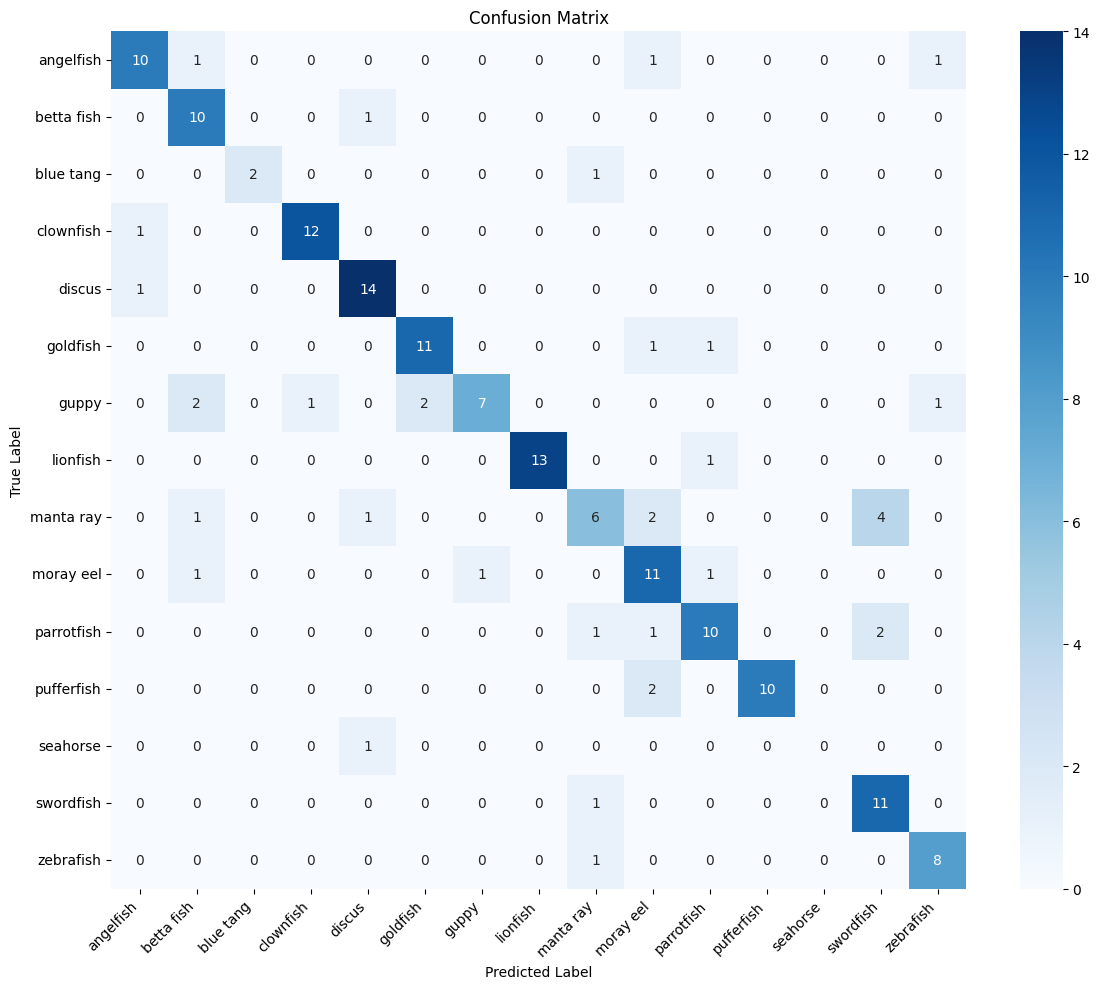


Testing: fish_dataset\angelfish\000060.jpg


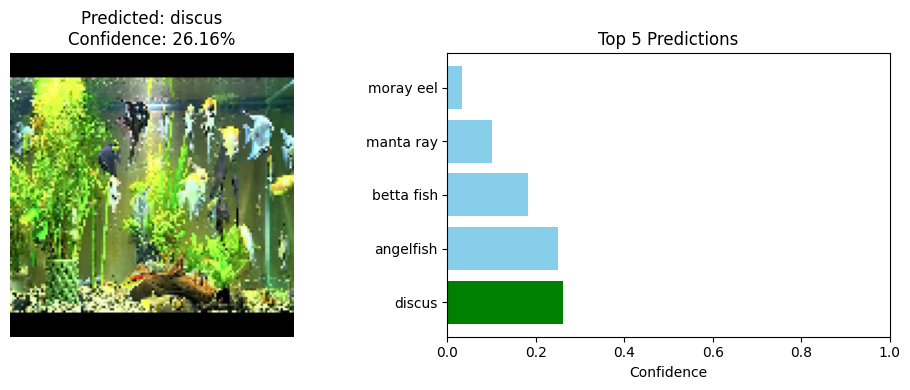

✅ Result: discus (26.16% confidence)

Testing: fish_dataset\betta fish\000039.jpg


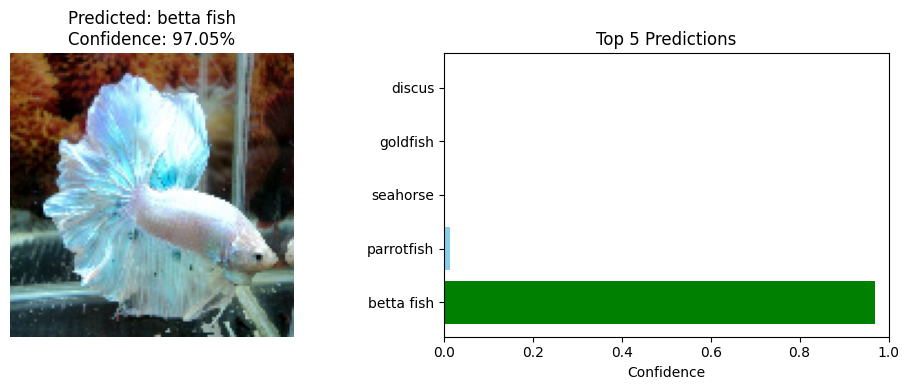

✅ Result: betta fish (97.05% confidence)

Testing: fish_dataset\blue tang\000003.jpg


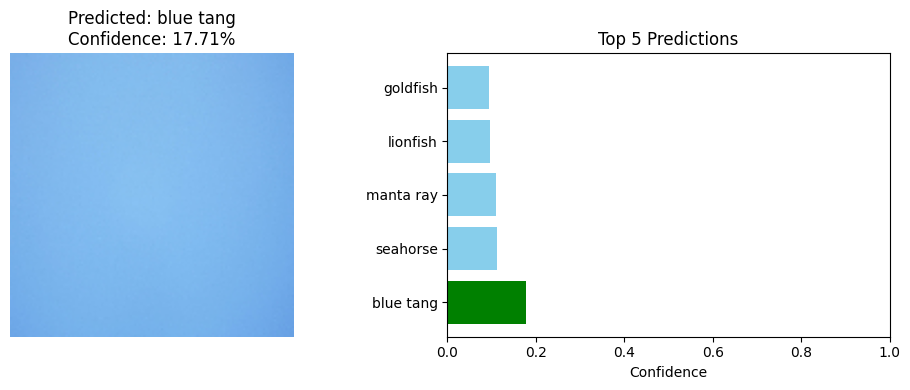

✅ Result: blue tang (17.71% confidence)

Testing: fish_dataset\clownfish\000031.jpg


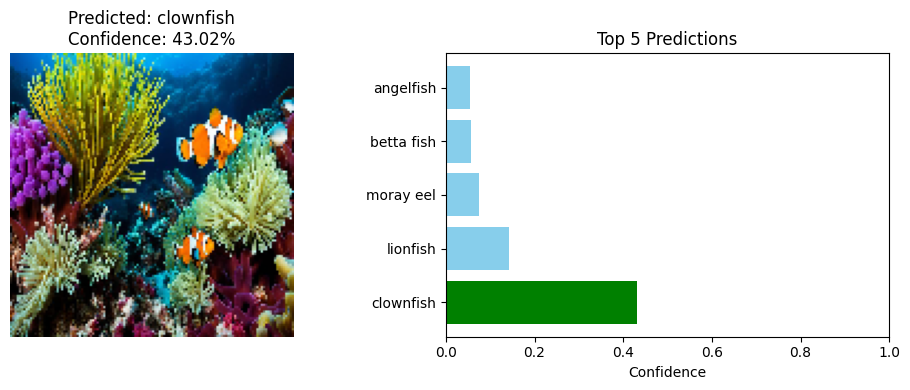

✅ Result: clownfish (43.02% confidence)

Testing: fish_dataset\discus\000067.jpg


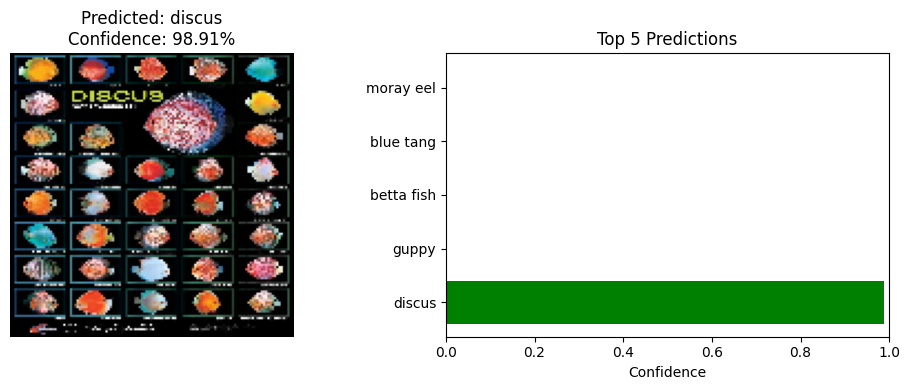

✅ Result: discus (98.91% confidence)

🎉 MODEL TRAINING COMPLETE!
✅ Best model saved: best_fish_model.keras
✅ Final model saved: final_fish_model.keras
✅ Number of classes: 15
✅ Classes: angelfish, betta fish, blue tang, clownfish, discus, goldfish, guppy, lionfish, manta ray, moray eel, parrotfish, pufferfish, seahorse, swordfish, zebrafish

To predict a new image, use:
predict_fish('path/to/image.jpg', model, class_names)


In [10]:


# ============================================================================
# Cell 8: Plot Training History
# ============================================================================

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# ============================================================================
# Cell 9: Evaluate Model
# ============================================================================

model = keras.models.load_model('best_fish_model.keras')

validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

print("\n📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# ============================================================================
# Cell 10: Confusion Matrix
# ============================================================================

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# Cell 11: Prediction Function
# ============================================================================

from tensorflow.keras.preprocessing import image

def predict_fish(img_path, model, class_names):
    """Predict fish species from an image"""
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    top_5_probs = predictions[0][top_5_idx]
    top_5_classes = [class_names[i] for i in top_5_idx]
    
    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
    plt.barh(top_5_classes, top_5_probs, color=colors)
    plt.xlabel('Confidence')
    plt.title('Top 5 Predictions')
    plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence

# ============================================================================
# Cell 12: Test on Sample Images
# ============================================================================

import random

test_samples = []
for class_name in class_names[:5]:
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)
    if images:
        random_img = random.choice(images)
        test_samples.append(os.path.join(class_path, random_img))

for img_path in test_samples:
    print(f"\n{'='*60}")
    print(f"Testing: {img_path}")
    print('='*60)
    predicted_class, confidence = predict_fish(img_path, model, class_names)
    print(f"✅ Result: {predicted_class} ({confidence*100:.2f}% confidence)")

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*60)
print(f"✅ Best model saved: best_fish_model.keras")
print(f"✅ Final model saved: final_fish_model.keras")
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {', '.join(class_names)}")
print("\nTo predict a new image, use:")
print("predict_fish('path/to/image.jpg', model, class_names)")
print("="*60)